In [1]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os

import matplotlib
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from utils.data_manager import load_patient, normalize

import math
from sys import stdout

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.


In [155]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return K.sum(1 / (1 - K.abs(y_true_f - y_pred_f))) * 0.0001
    # return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return dice_coef(y_true, y_pred)


In [ ]:
last_model = load_model('single-pass-segment-detection-v2.h5')

In [156]:
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
model.save('single-pass-segment-detection-v2.h5')
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [57]:
c7w = last_model.layers[-2].get_weights()
c8w = last_model.layers[-1].get_weights()

new7w = [
    np.concatenate([c7w[0],np.zeros((3,3,35,32))], axis=3),
    np.concatenate([c7w[1],np.zeros(32)])
]

new8w = [
    np.concatenate([c8w[0],np.zeros((3,3,32,4))], axis=2),
    c8w[1]
]

In [104]:
model.layers[-1].set_weights(last_model.layers[-1].get_weights())

ValueError: Layer weight shape (1, 1, 64, 4) not compatible with provided weight shape (3, 3, 64, 4)

In [90]:
for idx, layer in enumerate(model.layers[:-3]):
    if layer.name.startswith('conv'):
        layer.set_weights(last_model.layers[idx].get_weights())

In [101]:
cut = last_model.layers[-2].output

c7p = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(cut)

c8 = Convolution2D(4, 1, 1, activation='sigmoid', border_mode='same')(c7p)



model = Model(input=last_model.input, output=c8)
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [113]:
p1 = np.load('data/benign016.npy')
p1
image = p1.all()['image']
tag = p1.all()['tag']
X = normalize(image.reshape(image.shape[0], 512, 512, 1))
y = tag.reshape(image.shape[0], 512, 512, 8)[:,:,:,[0,1,2,3]]
num = X.shape[0]
def generate(k):
    xx1 = []
    xx2 = []
    xx3 = []
    yy = []
    for i in range(k):
        c = np.random.randint(num - 2) + 1
        xx1.append(X[c-1])
        xx2.append(X[c])
        xx3.append(X[c+1])
        yy.append(y[c])
    return np.stack(xx1), np.stack(xx2), np.stack(xx3), np.stack(yy)


In [159]:
epoch = 30
batch = 20
for i in range(epoch):
    print('epoch %d' % i)
    loss = 0
    for j in range(batch):
        xx1, xx2, xx3, yy = generate(1)
        l = model.train_on_batch([xx1, xx2, xx3], yy)
        loss += l[1]
        stdout.write('\rBatch %d : loss %f' % (j + 1, loss / (j + 1)))
    print("")

epoch 0
Batch 20 : loss 112.469562
epoch 1
Batch 20 : loss 112.906981
epoch 2
Batch 20 : loss 112.737052
epoch 3
Batch 20 : loss 112.080760
epoch 4
Batch 20 : loss 111.486469
epoch 5
Batch 20 : loss 111.287124
epoch 6
Batch 20 : loss 112.506056
epoch 7
Batch 20 : loss 110.979722
epoch 8
Batch 20 : loss 110.646421
epoch 9
Batch 20 : loss 112.526423
epoch 10
Batch 12 : loss 111.746520

KeyboardInterrupt: 

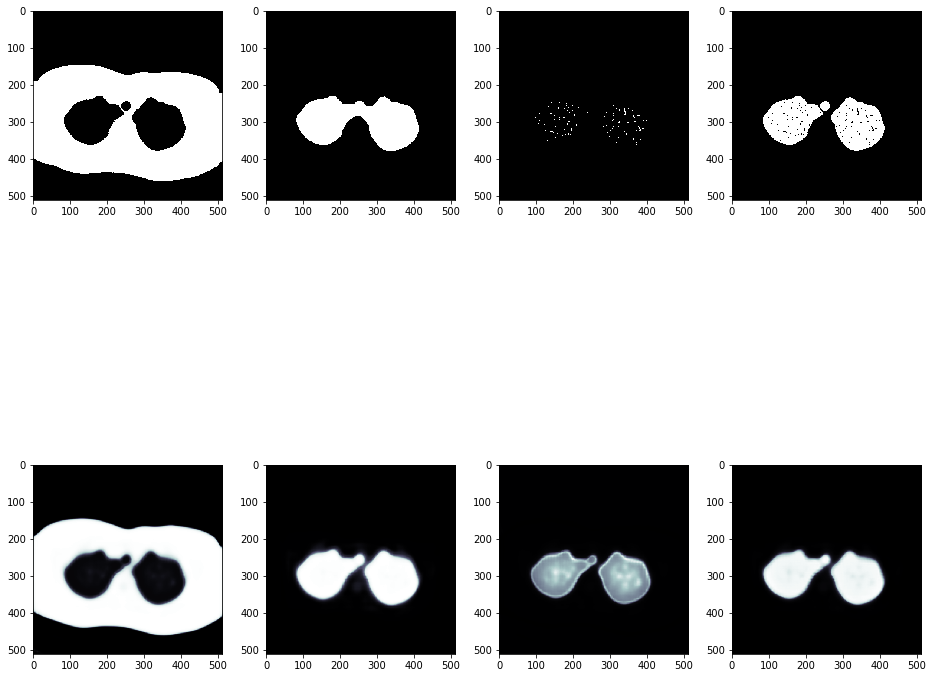

In [160]:
xx1, xx2, xx3, yy = generate(1)
pred = model.predict([xx1, xx2, xx3])[0] ## for a slice
plt.figure(figsize=(16,16))
for i in range(4):
    plt.subplot(4,4, i+1)
    plt.imshow(yy[0,:,:,i], plt.cm.bone)

for i in range(4):
    plt.subplot(4,4, 8 + i+1)
    plt.imshow(pred[:,:,i], plt.cm.bone)
plt.show()